In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import SpectralMethods as sm


In [13]:
# Initialize Magnet and System classes for simulation

class Magnet:
    def __init__(self, position, momentum):
        self.position = np.array(position)
        self.momentum = np.array(momentum)
        
    def potential(self, theta, mu0=1, l=1):
        # Calculate the potential energy of the pendulum at a given angle theta
        pendulum_direction = np.array([np.sin(theta), np.cos(theta)])
        pendulum_position = l * pendulum_direction
        pendulum_momentum = pendulum_direction
        
        # Calculate the magnetic field at the pendulum's position
        r = pendulum_position - self.position
        r_norm = np.linalg.norm(r)
        B = (mu0 / 4 * np.pi) * (3 * r * r.dot(self.momentum) - self.momentum) / (r_norm**5)
        
        # Calculate the potential energy from the magnetic field
        Um = -pendulum_momentum.dot(B)
        
        return Um
    
    def potential_derivative(self, theta, mu0=1, dtheta=1e-5, l=1):
        # Finite difference derivative of the potential energy
        val0 = self.potential(theta - dtheta, mu0=mu0, l=l)
        val1 = self.potential(theta + dtheta, mu0=mu0, l=l)
        
        return (val1 - val0) / (2 * dtheta)

class System:
    def __init__(self, ic=[0, 0], length=1, moment=1, t_max=100, dt=0.1, g=1, mu0=1, damp=0.2):
        self.angle = ic[0]
        self.velocity = ic[1]
        self.length = length
        self.moment = moment
        self.t_max = t_max
        self.dt = dt
        self.g = g
        self.damp = damp
        self.mu0 = mu0
        
        self.magnets = []
        self.angle_list = []
        self.velocity_list = []
        self.critical_points = []
        
    def add_magnet(self, magnet):
        self.magnets.append(magnet)
        
    def rhs(self, state):
        # Calculate the next state from the right-hand side of the system of first order ODEs
        angle = state[0]
        velocity = state[1]
        
        dL = -self.g / self.length * np.sin(angle) - self.damp * velocity
        
        for magnet in self.magnets:
            dL += magnet.potential_derivative(state[0], mu0=self.mu0, l=self.length)
        
        # Return according to definition of the first order system
        return np.array([
            state[1], 
            dL
        ])
        
    def rk4_step(self, state):
        # Standard Runge-Kutta 4th order time-stepping scheme
        k1 = self.rhs(state)
        k2 = self.rhs(state + self.dt / 2 * k1)
        k3 = self.rhs(state + self.dt / 2 * k2)
        k4 = self.rhs(state + self.dt * k3)
        
        return state + self.dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        
    def solve(self, save=True):
        # Number of simulation time steps
        num_steps = int(self.t_max / self.dt)
        
        # Initialize solution trajectory
        state = np.array([self.angle, self.velocity])
        trajectory = [state]
        
        # Simulate the system using Runge-Kutta time-stepping
        for _ in range(num_steps - 1):
            trajectory.append(self.rk4_step(trajectory[-1]))
        
        trajectory = np.array(trajectory)
        
        # Save the results to the object
        self.angle_list = trajectory[:, 0]
        self.velocity_list = trajectory[:, 1]
        self.critical_points = self.get_critical_angles()
        
        # Save the results for animation purposes
        if save:
            np.save("angle_list.npy", self.angle_list)
            np.save("velocity_list.npy", self.velocity_list)
            magnets = np.array([np.concatenate([magnet.position, magnet.momentum]) for magnet in self.magnets])
            np.save("magnets.npy", magnets)
            np.save("critical_points.npy", self.critical_points)
    
    def plot_solution(self, ax=None, color=None):
        # Plot the angle trajectory as function of time
        if ax is None:
            fig, ax = plt.subplots()
            
        ax.set_title("Solution")
        ax.set_xlabel("Time")
        ax.set_ylabel("Angle")
        
        time_steps = np.linspace(0, self.t_max, len(self.angle_list))
        plt.plot(time_steps, self.angle_list, color=color)
    
    def plot_potential(self, ax=None, color=None, resolution=500):
        # Plot the potential energy of the system as a function of angle
        if ax is None:
            fig, ax = plt.subplots()
                
        # Calculate the total potential energy of the system 
        def total_potential(angle):
            potential = self.g / self.length * (1 - np.cos(angle))  # Gravitational potential, reference at (x,y) = (0,l)
            for magnet in self.magnets:
                potential -= magnet.potential(angle, mu0=self.mu0, l=self.length)
                
            return potential
        
        angles = np.linspace(-np.pi, np.pi, resolution, endpoint=False)
        
        potentials = [total_potential(angle) for angle in angles]
        plt.plot(angles, potentials, color=color)
        
        return potentials
    
    def plot_potential_derivative(self, ax=None, color=None, resolution=500):
        # Plot the derivative of the potential energy as a function of angle
        if ax is None:
            fig, ax = plt.subplots()
        
        # ax.set_xlabel("Angle")
        # ax.set_ylabel("Potential")
        
        angles = np.linspace(-np.pi, np.pi, resolution, endpoint=False)
        
        dpotentials = [self.rhs([angle, 0])[1] for angle in angles]
        plt.plot(angles, dpotentials, color=color)
        
        return dpotentials
    
    def get_critical_angles(self):
        critical_angles = []
        initial_angles = np.linspace(-np.pi, np.pi, 500, endpoint=False)
        
        tol = 1e-5
        for angle in initial_angles:
            # Find the roots of the derivate of potential - root works better than fsolve
            new_crit_angle = root(self.rhs, [angle, 0]).x[0] % (2 * np.pi)
            
            # Only add new critical point, if it is not already in the list _AND_ if it is sufficiently close to zero
            is_new = True
            for crit_angle in critical_angles:
                if np.abs(crit_angle - new_crit_angle) < tol or np.abs(crit_angle - (new_crit_angle - 2 * np.pi)) < tol:
                    is_new = False
                    break
                if np.abs(self.rhs([new_crit_angle, 0])[1]) > 1e-8:
                    is_new = False
                    break
            if is_new:
                critical_angles.append(new_crit_angle)
            
        return (np.array(critical_angles) + np.pi) % (2 * np.pi) - np.pi
    
    def check_stability(self, critical_angle, dtheta=1e-6):
        # Finite difference derivative for finding the second derivative
        val0 = self.rhs([critical_angle - dtheta, 0.0])[1]
        val1  = self.rhs([critical_angle + dtheta, 0.0])[1]
        
        return (val1 - val0) / (2 * dtheta)


def strength_bifurcation(magnet_pos=None, ax=None, angle_range=[-np.pi * 1.2, np.pi * 1.2], strength_range=[-1, 1], resolution=100):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set_title("Bifurcation Diagram")
    ax.set_xlabel("Magnet strength")
    ax.set_ylabel("Angle")
    ax.set_ylim(angle_range)
    ax.grid(True)
    
    # Find critical angles for each magnet strength
    strengths = np.linspace(strength_range[0], strength_range[1], resolution)
    critical_angles = []
    for i, strength in enumerate(strengths):
        print(i, end=" ")  # Debugging
        
        # Initialize system, add magnet and find critical angles
        system = System()
        if magnet_pos is not None:
            magnet = Magnet(magnet_pos, [0, strength])
            system.add_magnet(magnet)
        
        crit_temp = system.get_critical_angles()
        for crit_angle in crit_temp:
            # Append (strength, critical_angle) to list for bifurcation plot
            critical_angles.append([strength, crit_angle])
            # Get stability color
            if system.check_stability(crit_angle) < 0:
                # stable
                color = "#2F3EEA"
            else:
                # unstable
                color = "#E83F48"
            
            ax.plot([strength], [crit_angle], 'o', color=color)
    
def position_bifurcation(strength=1, ax=None, angle_range=[-np.pi * 1.2, np.pi * 1.2], position_range=[-1, 1], y_position=1.3, resolution=100):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.set_title("Bifurcation Diagram")
    ax.set_xlabel("Magnet position")
    ax.set_ylabel("Angle")
    ax.set_ylim(angle_range)
    ax.grid(True)
    
    # Find critical angles for each magnet strength
    positions = np.linspace(position_range[0], position_range[1], resolution)
    critical_angles = []
    for i, position in enumerate(positions):
        print(i, end=" ")  # Debugging
        
        # Initialize system, add magnet and find critical angles
        system = System()
        magnet = Magnet([position, y_position], [0, strength])
        system.add_magnet(magnet)
        
        crit_temp = system.get_critical_angles()
        for crit_angle in crit_temp:
            # Get stability color
            if system.check_stability(crit_angle) < 0:
                # stable
                color = "#2F3EEA"
            else:
                # unstable
                color = "#E83F48"
            
            ax.plot([position], [crit_angle], 'o', color=color)
    

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

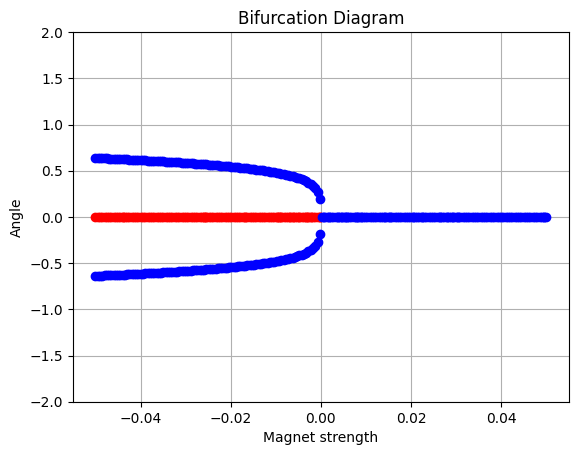

In [3]:
strength_bifurcation(magnet_pos=[0, 1.3], 
                     angle_range=[-2, 2], 
                     strength_range=[-0.05, 0.05], 
                     resolution=200
)

plt.savefig("bif_centered.pdf")


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

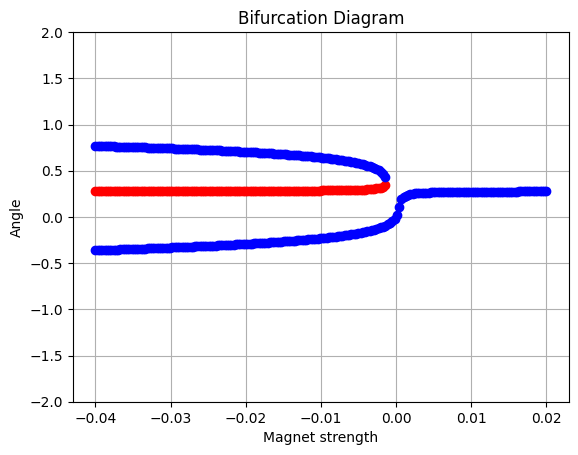

In [4]:
strength_bifurcation(magnet_pos=[0.4, 1.3], 
                     angle_range=[-2, 2], 
                     strength_range=[-0.04, 0.02], 
                     resolution=200
)

plt.savefig("bif_off-center.pdf")


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

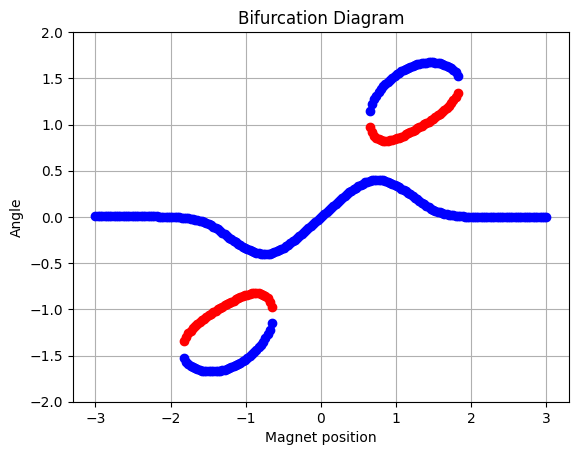

In [5]:
position_bifurcation(strength=1, 
                     angle_range=[-2, 2], 
                     position_range=[-3, 3], 
                     y_position=1.3, 
                     resolution=200
)

plt.savefig("bif_moving_attracting.pdf")


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

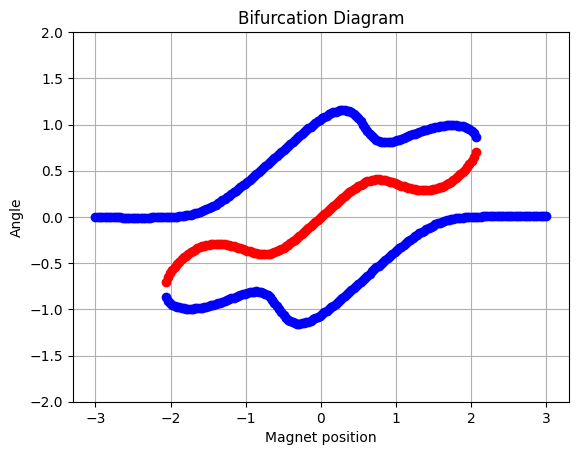

In [6]:
position_bifurcation(strength=-1,
                     angle_range=[-2, 2],
                     position_range=[-3, 3],
                     y_position=1.3,
                     resolution=200
)

plt.savefig("bif_moving_repelling.pdf")


[-3.14159265e+00 -6.39488462e-14  0.00000000e+00]


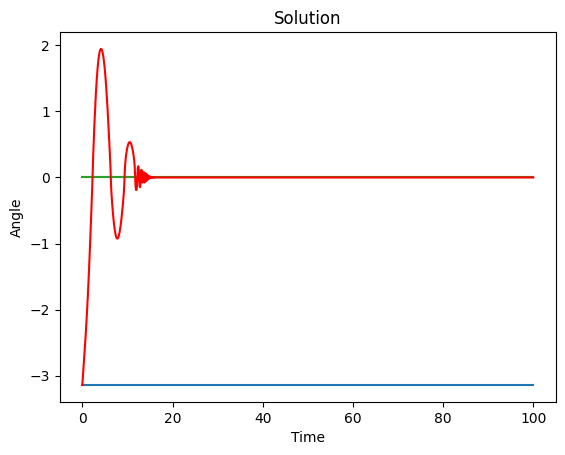

[1.2246467991473532e-16, 6.394884621840902e-14, 0.0]


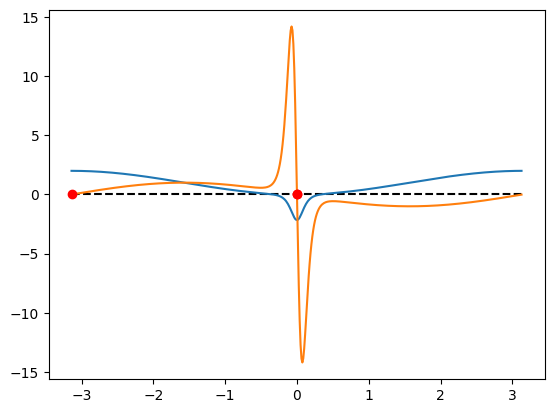

In [7]:
fig, ax = plt.subplots()

marcus = System(dt=0.1, t_max=100)
marcus.add_magnet(Magnet([0.0, 1.2], [0.0, 0.001]))
crit_points = marcus.get_critical_angles()
trajectory_values = []
print(crit_points)
for angle in crit_points:
# for angle in crit_points[::-1]:
    marcus.angle = angle
    marcus.velocity = 0
    marcus.solve()
    marcus.plot_solution(ax=ax)

marcus.angle = -np.pi * 0.999999999999999
marcus.velocity = 1
marcus.solve()
marcus.plot_solution(ax=ax, color="red")
plt.show()

fig, ax = plt.subplots()
ax.plot([-np.pi, np.pi], [0, 0], "k--")
p = marcus.plot_potential(ax=ax)
D = sm.fourier_diff_D(len(p))
marcus.plot_potential_derivative(ax=ax)
# ax.plot(np.linspace(-np.pi, np.pi, len(p)), -D.dot(p), "g")
ax.plot(crit_points, [0] * len(crit_points), "ro")

# print(marcus.rhs([1, 0]))
print([marcus.rhs([cp, 0])[1] for cp in crit_points])


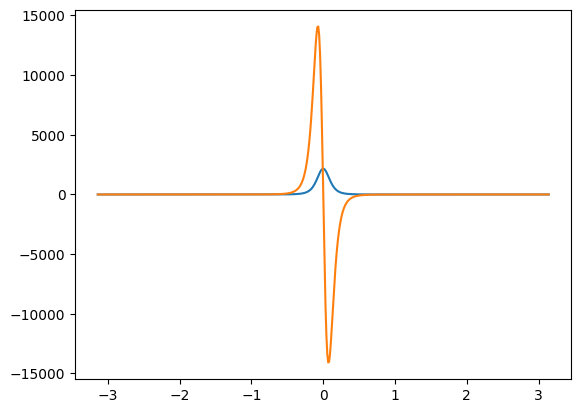

In [8]:
m = Magnet([0, 1.2], [0, 1])
thetas = np.linspace(-np.pi, np.pi, 500)
potentials = [m.potential(theta) for theta in thetas]
dpotentials = [m.potential_derivative(theta) for theta in thetas]
plt.plot(thetas, potentials)
plt.plot(thetas, dpotentials)
plt.show()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

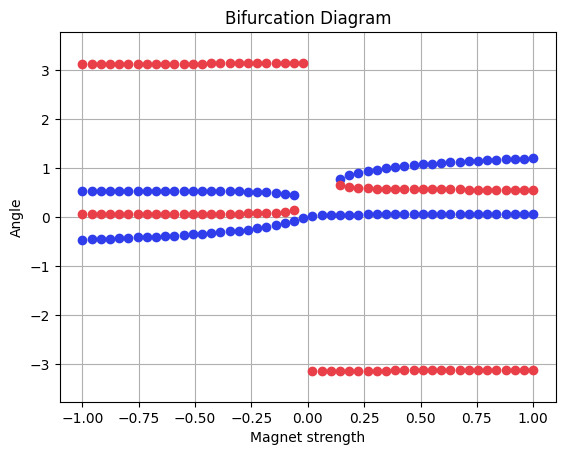

In [15]:
strength_bifurcation(magnet_pos=[0.6, 1.5], 
                 strength_range=[-1, 1], 
                #  angle_range=[-0.8, 0.8],
                 resolution=50
    )

plt.savefig("test.pdf")


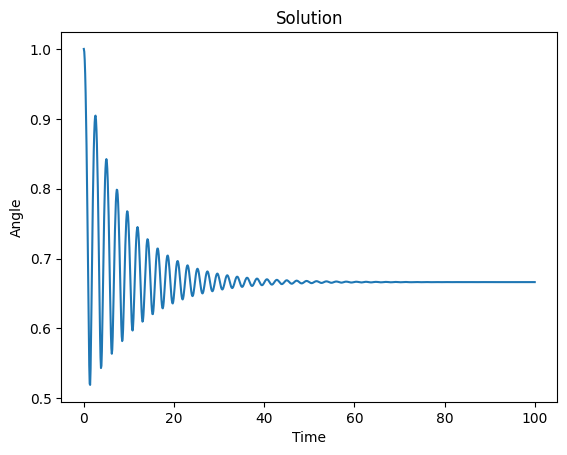

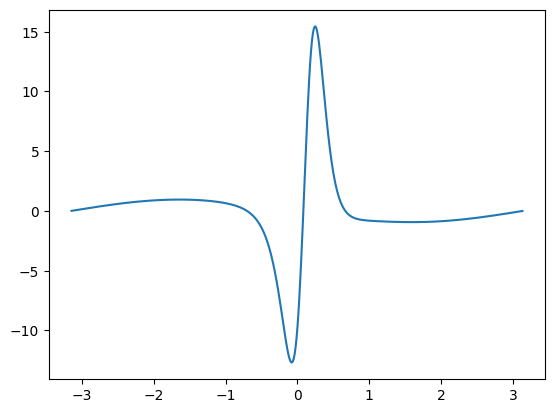

In [10]:
p = System(ic=[1, 0])
p.add_magnet(Magnet([0.2, 1.5], [0, -1]))
p.solve()
p.plot_solution()
plt.show()
p.plot_potential_derivative()
plt.show()
